In [91]:
from util import get_dummies, detect_str_columns,model_testRF,results_summary_to_dataframe,plot_confusion_matrix,logistic_model,logistic_importance,logistic_conf
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, accuracy_score,classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
# ----設定繪圖-------
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import platform

In [110]:
data = pd.read_excel('C:/Users/bbgog/paper/108_recruit_train.xlsx')
data = data[data['highest_school_level']!='F']
data['highest_school_level'] = data['highest_school_level'].astype('int')
data.head()

,id,sex,apply_age,marriage,highest_education,highest_graduation,loan,loan_status,military_status,aboriginal,height,weight,nationality,highest_school_level,english_level,interview,second_interview
0,R224211691,F,24,0,B,Y,0,1,1,0,162,60,1,3,2.0,1,0
1,R223936966,F,28,0,B,Y,1,1,1,0,158,52,1,2,2.0,0,0
2,F228161684,F,24,0,B,Y,1,1,1,0,164,70,1,3,2.0,0,0
3,O200443001,F,21,0,B,Y,0,1,1,0,152,41,1,5,2.0,0,0
4,N225966272,F,22,0,B,I,0,1,1,0,155,45,1,6,3.0,0,0


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188 entries, 0 to 1201
Data columns (total 17 columns):
id                      1188 non-null object
sex                     1188 non-null object
apply_age               1188 non-null int64
marriage                1188 non-null int64
highest_education       1188 non-null object
highest_graduation      1188 non-null object
loan                    1188 non-null int64
loan_status             1188 non-null int64
military_status         1188 non-null int64
aboriginal              1188 non-null int64
height                  1188 non-null int64
weight                  1188 non-null int64
nationality             1188 non-null int64
highest_school_level    1188 non-null int32
english_level           1188 non-null float64
interview               1188 non-null int64
second_interview        1188 non-null int64
dtypes: float64(1), int32(1), int64(11), object(4)
memory usage: 162.4+ KB


In [112]:
print('不錄取', round(data['second_interview'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('錄取', round(data['second_interview'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

不錄取 87.29 % of the dataset
錄取 12.71 % of the dataset


Text(0.5, 1.0, 'purchase decision \n (0:no vs 1:yes )')

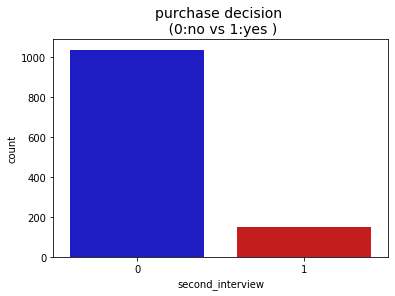

In [113]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('second_interview', data=data, palette=colors)
plt.title('purchase decision \n (0:no vs 1:yes )', fontsize=14)

# 檢視欄位並找出特徵值

In [114]:
# 偵測有字串的欄位
# str_columns = detect_str_columns(data)
str_columns = ['sex', 'highest_education', 'highest_graduation']
print(str_columns)

['sex', 'highest_education', 'highest_graduation']


In [115]:
dataset = get_dummies(str_columns, data)
dataset.head()

,id,apply_age,marriage,loan,loan_status,military_status,aboriginal,height,weight,nationality,...,interview,second_interview,sex_F,sex_M,highest_education_B,highest_education_D,highest_education_M,highest_graduation_D,highest_graduation_I,highest_graduation_Y
0,R224211691,24,0,0,1,1,0,162,60,1,...,1,0,1,0,1,0,0,0,0,1
1,R223936966,28,0,1,1,1,0,158,52,1,...,0,0,1,0,1,0,0,0,0,1
2,F228161684,24,0,1,1,1,0,164,70,1,...,0,0,1,0,1,0,0,0,0,1
3,O200443001,21,0,0,1,1,0,152,41,1,...,0,0,1,0,1,0,0,0,0,1
4,N225966272,22,0,0,1,1,0,155,45,1,...,0,0,1,0,1,0,0,0,1,0


In [116]:
data_school = dataset[dataset['english_level'].notnull()]
display(data_school[['highest_school_level','english_level']].groupby(by='highest_school_level').mean())
display(data_school[['highest_school_level','english_level']].groupby(by='highest_school_level').median())

,english_level
highest_school_level,
1,2.125000
2,2.093458
3,2.116608
4,2.983945
5,2.230769
6,2.984925
7,3.679245


,english_level
highest_school_level,
1,2.0
2,2.0
3,2.0
4,3.0
5,2.0
6,3.0
7,4.0


In [117]:
X =dataset.drop(columns=['second_interview'])
y =dataset['second_interview']

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [119]:
X_train.shape

(950, 21)

In [120]:
y_train.shape

(950,)

In [121]:
X_test.shape

(238, 21)

In [122]:
y_test.shape

(238,)

In [125]:
# 保留UID
train_uid = X_train['id']
test_uid = X_test['id']

In [126]:
# 設定xgb 分類模型
del X_train['id']
del X_test['id']

In [127]:
logistic_reg =LogisticRegression()

In [128]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_logistic = sc.fit_transform(X_train)
X_test_logistic = sc.transform(X_test)

In [129]:
# 進行訓練
logistic_reg.fit(X_train_logistic, y_train)

C:\Users\bbgog\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
# 預測
logistic_pred = logistic_reg.predict(X_test_logistic)

In [131]:
# 預測機率
logistic_pred_proba = logistic_reg.predict_proba(X_test_logistic) 

In [132]:
# 準確率
accuracy_score(y_test, logistic_pred)

0.8613445378151261

C:\Users\bbgog\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



################ summary ################ 
[[205   3]
 [ 30   0]]
Training Accuracy = 0.880
Test Accuracy = 0.861


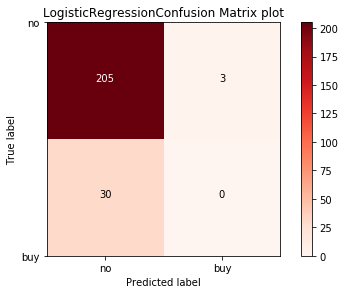

In [133]:
# confusion matrix plot
model_testRF( LogisticRegression(), 
             X_train_logistic,y_train,X_test_logistic,y_test, plot_name = 'LogisticRegression')